In [19]:
%matplotlib inline
import csv
import math
import datetime
import numpy as np
import matplotlib.pyplot as plt
from pylab import hist2d

In [2]:
import matplotlib as mpl
cmapp = mpl.colors.LinearSegmentedColormap.from_list('my_cmap',['blue','red'],256)
cmapp._init()
alphas = np.linspace(0, 0.8, cmapp.N+3)
cmapp._lut[:,-1] = alphas

In [3]:
def datetime_range(start=None, end=None):
    span = end - start
    for i in xrange(span.days + 1):
        yield start + datetime.timedelta(days=i)

In [4]:
hr_bin = 3.0;

datX = []
datL = []
with open('input/crimes.csv', 'rb') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for dat in reader:
        try:
            tim = datetime.datetime.strptime(dat[2], "%m/%d/%Y %I:%M:%S %p")
            lat = float(dat[19])
            lng = float(dat[20])
            datX.append([lat,lng,tim.hour,tim.weekday(),tim.month,tim.year])
            datL.append([dat[5],dat[7]])
        except:
            pass
X = np.array(datX);
L = np.array(datL);

In [5]:
L[np.char.find(L[:,1],'AIR')>=0,1]='AIRPORT'
L[np.char.find(L[:,0],'NON')>=0,0]='NON-CRIMINAL'
L[np.char.find(L[:,1],'CTA')>=0,1]='CTA'

keep = np.logical_or(np.char.find(L[:,1],'STREET')>=0,np.logical_or(np.char.find(L[:,1],'SIDEWALK')>=0,np.logical_or(L[:,1]=='OTHER',np.logical_or(np.char.find(L[:,1],'LOT/GARAGE')>=0,np.logical_or(L[:,1]=='ALLEY',np.char.find(L[:,1],'CTA')>=0)))))
keep = np.logical_and(keep, np.logical_not(np.logical_or(np.char.find(L[:,0],'ARSON')>=0,np.logical_or(np.char.find(L[:,0],'CARRY')>=0,np.logical_or(np.char.find(L[:,0],'HUMAN')>=0,np.logical_or(np.char.find(L[:,0],'INDECENCY')>=0,np.logical_or(np.char.find(L[:,0],'LIQUOR')>=0,np.logical_or(np.char.find(L[:,0],'GAMBLING')>=0,np.logical_or(np.char.find(L[:,0],'PROSTITUTION')>=0,np.logical_or(np.char.find(L[:,0],'STALKING')>=0,np.logical_or(np.char.find(L[:,0],'KIDNAPPING')>=0,np.logical_or(np.char.find(L[:,0],'INTIMIDATION')>=0,np.logical_or(np.char.find(L[:,0],'OBSCENITY')>=0,np.char.find(L[:,0],'NARCOTICS')>=0)))))))))))))
keep = np.logical_and(keep,X[:,1]>-87.9)
L=L[keep,:]
X=X[keep,:]

In [6]:
H, yedges, xedges = np.histogram2d(X[:,0], X[:,1], bins=80)

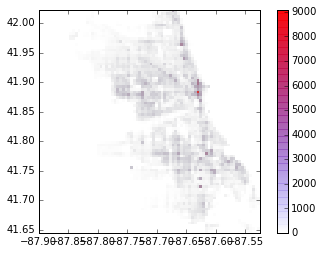

In [7]:
plt.imshow(H,cmap=cmapp,interpolation='none',origin='low',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar();

In [8]:
fX = X
from scipy import interpolate
f_x = interpolate.interp1d(xedges, xedges,kind='nearest')
fX[:,1] = f_x(fX[:,1])

f_y = interpolate.interp1d(yedges, yedges,kind='nearest')
fX[:,0] = f_y(fX[:,0])

fX[:,2]=np.floor(fX[:,2]/hr_bin)*hr_bin

In [9]:
# This method sucks but I used it for a while thinking I was being so numpy-brilliant
# setX ={tuple(row) for row in X}
# binX = np.vstack(temX)
# binY = np.zeros((binX.shape[0],1))
# for i in range(binX.shape[0]):
#     binY[i,0] = (~np.any(X- binX[i], 1)).sum()

In [10]:
mak = {}
for row in fX:
    v = tuple(row)
    if(v in mak):
        mak[v]=mak[v]+1
    else:
        mak[v]=1.
makk = np.vstack(mak.items())
binX = np.vstack(makk[:,0])
binY = np.vstack(makk[:,1])

In [11]:
cntT = {}
for tim in datetime_range(datetime.datetime(2001, 1, 1),datetime.datetime(2014, 1, 1)):
    tup = (tim.weekday(),tim.month)
    if(tup in cntT):
        cntT[tup]=cntT[tup]+1
    else:
        cntT[tup]=1.

In [12]:
for i in range(binY.shape[0]):
    n=cntT[(binX[i,3],binX[i,4])]
    binY[i]=float(binY[i])/n/hr_bin

In [13]:
r_num = 800000
r_lat = 41.65+np.random.uniform(size=r_num)*0.35
r_off = np.random.uniform(size=r_num)*0.2
r_lon = -87.55 - (r_lat-41.75)/0.25*0.1 - r_off
r_hr = np.random.randint(24/hr_bin,size=r_num)*hr_bin
r_dy = np.random.randint(7,size=r_num)
r_mn = np.random.randint(1,13,size=r_num)

addX = np.array([r_lat,r_lon,r_hr,r_dy,r_mn]).T
addX = addX[addX[:,1]<=-87.55,:]

In [14]:
addH, yedges, xedges = np.histogram2d(addX[:,0], addX[:,1], bins=80)
plt.imshow(addH,cmap=cmapp,interpolation='none',origin='low',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar();

In [15]:
addX[:,1] = f_x(addX[:,1])
addX[:,0] = f_y(addX[:,0])
temX = np.vstack({tuple(row) for row in addX}.difference(makk[:,0]))

In [16]:
finX = np.vstack((binX,temX))
finY = np.vstack((binY,np.zeros((temX.shape[0],1))))

In [ ]:
import sklearn.ensemble as ske
rfr = ske.RandomForestRegressor(n_estimators=100)

from sklearn.svm import SVR
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_lin = SVR(kernel='linear', C=1e3)
svr_poly = SVR(kernel='poly', C=1e3, degree=2)

In [ ]:
scors = []
fracs = [0.1,0.2,0.3,0.4,0.5,0.6]
for samplefrac in fracs:
    print samplefrac
    samples = np.random.rand(finY.shape[0])<samplefrac
    X_train = finX[samples, :]
    X_test = finX[np.invert(samples), :]
    Y_train = np.ravel(finY[samples])
    Y_test = np.ravel(finY[np.invert(samples)])

    
    
#     s_rbf = svr_rbf.fit(X_train, Y_train).score(X_test,Y_test)
#     s_lin = svr_lin.fit(X_train, Y_train).score(X_test,Y_test)
#     s_poly = svr_poly.fit(X_train, Y_train).score(X_test,Y_test)
    s_rfr = rfr.fit(X_train,Y_train).score(X_test,Y_test)
    scors.append([s_rfr])

In [ ]:
plt.plot([0.1,0.2,0.3,0.4,0.5,0.6],scors)